

> Cell 1 – Install, imports, and mount Google Drive



In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Core libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# PyTorch and torchvision
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms


Mounted at /content/drive


Cell 2 – Set dataset path and image transforms

In [2]:
# Path to your dataset root folder in Google Drive
# Inside "Etsy Images", you should have two subfolders:
# - Etsy Images/logo
# - Etsy Images/non_logo
data_dir = "/content/drive/MyDrive/Etsy Images"

# Transforms for the training set:
# - Resize all images to 500x500
# - Randomly flip horizontally (data augmentation)
# - Convert to tensor
# - Normalize using ImageNet-like mean/std
train_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Transforms for the validation set (no random augmentation)
val_transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


Cell 3 – Create dataset and train/validation split

In [3]:
# Use ImageFolder to assign labels based on subfolder names
# 'logo' and 'non_logo' become class names 0 and 1 (or vice versa)
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
class_names = full_dataset.classes

print("Classes:", class_names)
print("Total images:", len(full_dataset))

# Split into train and validation sets (80% train, 20% validation)
train_ratio = 0.8
train_size = int(train_ratio * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Make sure validation subset uses the validation transform
val_dataset.dataset.transform = val_transform

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))


Classes: ['logo', 'non_logo']
Total images: 81
Train size: 64
Validation size: 17


Cell 4 – Create DataLoaders

In [4]:
# Number of images per batch
batch_size = 8

# DataLoader for training data (shuffled each epoch)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# DataLoader for validation data (no need to shuffle)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Quick sanity check
images, labels = next(iter(train_loader))
print("Batch image tensor shape:", images.shape)   # [batch_size, 3, 500, 500]
print("Batch label tensor shape:", labels.shape)   # [batch_size]


Batch image tensor shape: torch.Size([8, 3, 500, 500])
Batch label tensor shape: torch.Size([8])


Cell 5 – Define device, CNN model, loss, optimizer

In [5]:
# Use GPU if available in Colab (Runtime → Change runtime type → GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Simple CNN for binary classification (logo vs non_logo)
class RazorbackCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional feature extractor
        self.features = nn.Sequential(
            # Input: 3 x 500 x 500 -> 16 feature maps
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 500x500 -> 250x250

            # 16 x 250 x 250 -> 32 feature maps
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 250x250 -> 125x125

            # 32 x 125 x 125 -> 64 feature maps
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 125x125 -> 62x62
        )

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),                     # flatten feature maps
            nn.Linear(64 * 62 * 62, 256),     # dense layer
            nn.ReLU(),
            nn.Dropout(0.5),                  # dropout for regularization
            nn.Linear(256, 1)                 # single output for binary classification
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x  # logits

# Create model instance and move it to device
model = RazorbackCNN().to(device)

# Loss: Binary Cross Entropy with logits (works with single-output + sigmoid)
criterion = nn.BCEWithLogitsLoss()

# Optimizer: Adam with a small learning rate
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Using device: cpu


Cell 6 – Training and evaluation functions

In [6]:
# Train for one epoch on the training DataLoader
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        # Move to device
        inputs = inputs.to(device)
        labels = labels.to(device).float()  # BCE loss expects float labels

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze(1)  # shape: [batch_size]

        # Compute loss
        loss = criterion(outputs, labels)

        # Backprop
        loss.backward()
        optimizer.step()

        # Track loss
        running_loss += loss.item() * inputs.size(0)

        # Convert logits -> probabilities -> predicted class {0,1}
        preds = (torch.sigmoid(outputs) >= 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Evaluate on a given DataLoader without updating weights
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            outputs = model(inputs).squeeze(1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            preds = (torch.sigmoid(outputs) >= 0.5).long()
            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


Cell 7 – Training loop with best model tracking

In [7]:
num_epochs = 20

best_val_acc = 0.0
best_model_state = None

# Optional history dictionary for plotting later
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        print("New best model saved with val acc:", best_val_acc)


Epoch 1/20 Train Loss: 0.8706 Acc: 0.6250 Val Loss: 0.7048 Acc: 0.5882
New best model saved with val acc: 0.5882352941176471
Epoch 2/20 Train Loss: 0.7327 Acc: 0.6719 Val Loss: 0.8049 Acc: 0.5294
Epoch 3/20 Train Loss: 0.7482 Acc: 0.6250 Val Loss: 0.6399 Acc: 0.5294
Epoch 4/20 Train Loss: 0.5004 Acc: 0.7500 Val Loss: 0.6409 Acc: 0.5882
Epoch 5/20 Train Loss: 0.3921 Acc: 0.8750 Val Loss: 0.6320 Acc: 0.5882
Epoch 6/20 Train Loss: 0.3623 Acc: 0.9375 Val Loss: 0.6315 Acc: 0.5882
Epoch 7/20 Train Loss: 0.2781 Acc: 0.9375 Val Loss: 0.6367 Acc: 0.5882
Epoch 8/20 Train Loss: 0.2384 Acc: 0.9688 Val Loss: 0.6465 Acc: 0.6471
New best model saved with val acc: 0.6470588235294118
Epoch 9/20 Train Loss: 0.1333 Acc: 0.9844 Val Loss: 0.6631 Acc: 0.6471
Epoch 10/20 Train Loss: 0.1208 Acc: 0.9688 Val Loss: 0.6255 Acc: 0.7059
New best model saved with val acc: 0.7058823529411765
Epoch 11/20 Train Loss: 0.0756 Acc: 0.9844 Val Loss: 0.6117 Acc: 0.6471
Epoch 12/20 Train Loss: 0.0839 Acc: 0.9844 Val Loss: 0.

Cell 8 – Load best model and save as .ph

In [12]:
# Restore the best validation model weights
if best_model_state is not None:
    model.load_state_dict(best_model_state)

# Save the full model into Google Drive
save_path = "/content/drive/MyDrive/Group_10_CNN_FullModel.ph"
torch.save(model, save_path)

print("Model saved to:", save_path)
print("Best validation accuracy:", best_val_acc)


Model saved to: /content/drive/MyDrive/Group_10_CNN_FullModel.ph
Best validation accuracy: 0.7058823529411765


Cell 9 – Show a random validation images and prediction (1/0)

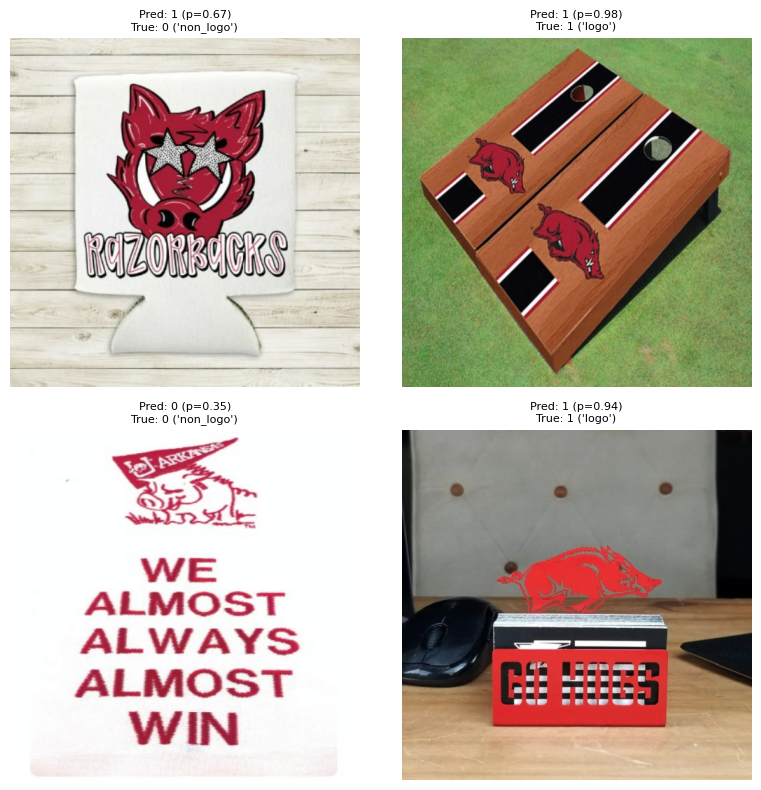

In [11]:
# Inverse normalization values for display (same as before)
inv_mean = np.array([0.485, 0.456, 0.406])
inv_std  = np.array([0.229, 0.224, 0.225])

import math  # for computing grid size

def show_random_predictions_grid(model, dataset, class_names, device, n_images=4):
    model.eval()

    # Make sure we don't ask for more images than exist
    n_images = min(n_images, len(dataset))

    # Randomly choose indices from the dataset (no replacement)
    indices = random.sample(range(len(dataset)), n_images)

    # Set up subplot grid (2x2 by default for 4 images)
    cols = 2
    rows = math.ceil(n_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
    axes = np.array(axes).reshape(-1)  # flatten in case of 1D

    for ax, idx in zip(axes, indices):
        # Get (image_tensor, label) from dataset
        img_tensor, label = dataset[idx]

        # Prepare single-image batch
        input_tensor = img_tensor.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor).squeeze(1)
            prob = torch.sigmoid(output).item()  # probability for class 1

        pred_binary = 1 if prob >= 0.5 else 0

        # Undo normalization for plotting
        img = img_tensor.permute(1, 2, 0).cpu().numpy()
        img = inv_std * img + inv_mean
        img = np.clip(img, 0, 1)

        # True label information
        true_class_name = class_names[label]
        true_binary = 1 if true_class_name == "logo" else 0

        ax.imshow(img)
        ax.axis("off")
        title = (
            f"Pred: {pred_binary} (p={prob:.2f})\n"
            f"True: {true_binary} ('{true_class_name}')"
        )
        ax.set_title(title, fontsize=8)

    # Turn off any unused subplots (if n_images < rows*cols)
    for ax in axes[n_images:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Call the function to visualize 4 random validation images
show_random_predictions_grid(model, val_dataset, class_names, device, n_images=4)
